<a href="https://colab.research.google.com/github/naenumtou/statisticalModel/blob/main/nonMaximumSuppression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

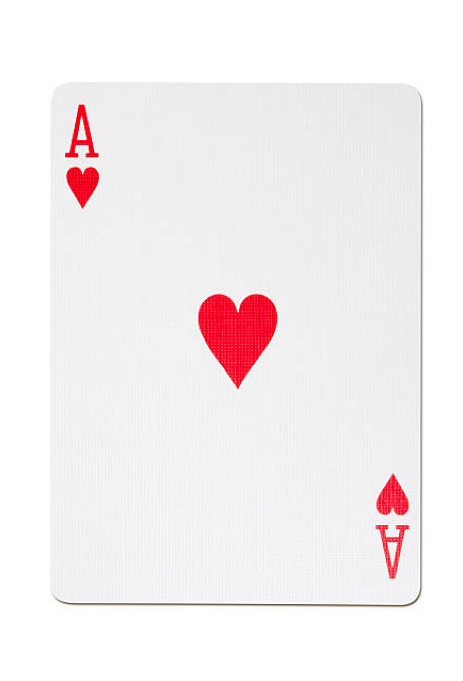

In [ ]:
# Read card image from URL
urlCard = 'https://raw.githubusercontent.com/naenumtou/statisticalModel/main/datasets/card.jpg'

resp = urllib.request.urlopen(urlCard).read()
imageCard = np.asarray(
    bytearray(resp),
    dtype = 'uint8'
)
imageCard = cv2.imdecode(imageCard, cv2.IMREAD_COLOR)
plt.figure(figsize = (10, 6))
plt.imshow(imageCard[:, :, ::-1])
plt.axis('off')
plt.show()

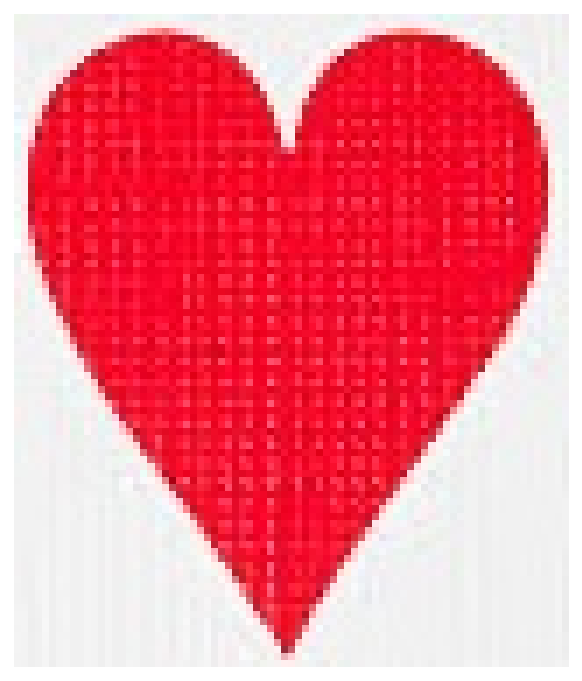

In [ ]:
# Read card target from URL
urlTarget = 'https://raw.githubusercontent.com/naenumtou/statisticalModel/main/datasets/targetCard.jpg'

resp = urllib.request.urlopen(urlTarget).read()
imageTarget = np.asarray(
    bytearray(resp),
    dtype = 'uint8'
)
imageTarget = cv2.imdecode(imageTarget, cv2.IMREAD_COLOR)
plt.figure(figsize = (10, 6))
plt.imshow(imageTarget[:, :, ::-1])
plt.axis('off')
plt.show()

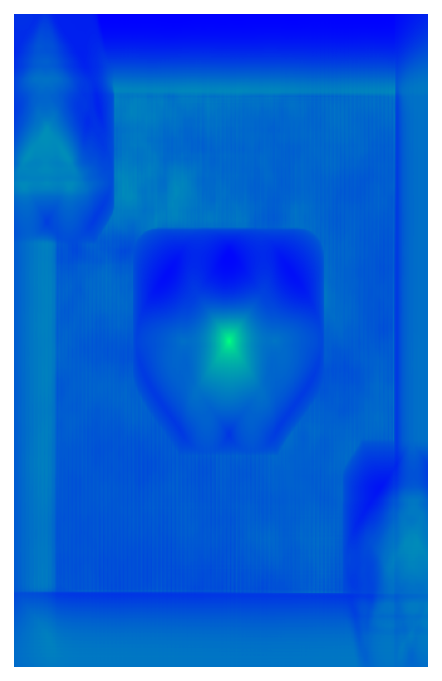

In [ ]:
# Using template matching to find target
imgGray = cv2.cvtColor(imageCard, cv2.COLOR_BGR2GRAY)
targetGray = cv2.cvtColor(imageTarget, cv2.COLOR_BGR2GRAY)

corr = cv2.matchTemplate(
    imgGray,
    targetGray,
    cv2.TM_CCOEFF_NORMED
)

plt.figure(figsize = (10, 6))
plt.imshow(corr, cmap = 'winter')
plt.axis('off')
plt.show()

In [ ]:
# Define function to find the box
def boxFinding(image, target, threshold):
  h, w = target.shape[0], target.shape[1] #Height and width of target
  # To gray scale
  imgGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  targetGray = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)
  # Matching the correlation
  corr = cv2.matchTemplate(
      imgGray,
      targetGray,
      cv2.TM_CCOEFF_NORMED
  )
  (y1, x1) = np.where(corr >= threshold) #Correlation above threshold
  # Create empty box
  boxes = np.zeros((len(y1), 4)) #4 means (x, y, h, w)
  x2 = x1 + w
  y2 = y1 + h
  # Fill the box
  boxes[:, 0] = x1
  boxes[:, 1] = y1
  boxes[:, 2] = x2
  boxes[:, 3] = y2
  return boxes.astype(int)

In [ ]:
# Box finding
boxesTarget = boxFinding(imageCard, imageTarget, 0.75)
print(f'Total boxes found: {len(boxesTarget)}')

Total boxes found: 102


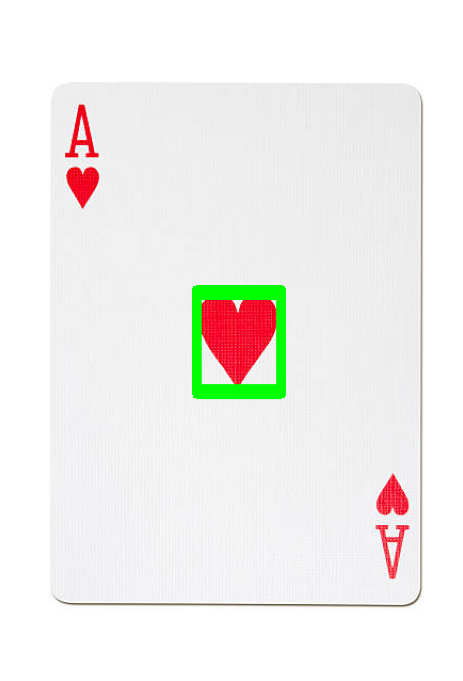

In [ ]:
# Draw correlation result
imageDraw = imageCard.copy()

plt.figure(figsize = (10, 6))
for box in boxesTarget:
  cv2.rectangle(
      imageDraw,
      (box[0], box[1]),
      (box[2], box[3]),
      (0, 255, 0),
      1
  )
  plt.imshow(imageDraw[:, :, ::-1])
  plt.axis('off')
plt.show()

In [ ]:
# Define function Non-Maximum Suppression
def nonMaxS(boxes, overlap):
  if len(boxes) == 0:
    return print('Cannot find the object')
  x1 = boxes[:, 0]
  y1 = boxes[:, 1]
  x2 = boxes[:, 2]
  y2 = boxes[:, 3]
  # Find area of the box
  areas = (x2 - x1 + 1) * (y2 - y1 + 1) #+1 for at least 1 pixel
  indices = np.arange(len(x1)) #Create index range
  # Find possible range
  for i, box in enumerate(boxes):
    index = indices[indices != i] #Drop current position
    xx1 = np.maximum(box[0], boxes[index, 0]) #Compare with other position
    yy1 = np.maximum(box[1], boxes[index, 1])
    xx2 = np.minimum(box[2], boxes[index, 2])
    yy2 = np.minimum(box[3], boxes[index, 3]) #Return with condition array
    # Calculate height and width
    w = np.maximum(0, xx2 - xx1 + 1) #+1 for at least 1 pixel
    h = np.maximum(0, yy2 - yy1 + 1)
    # Calculate overlap ratio
    overlapValue = (w * h) / areas[index]
    if np.any(overlapValue) > overlap:
      indices = indices[indices != i] #More than threshold will be eliminated
  return boxes[indices][0].astype(int)

In [ ]:
# Find the final box
boxFinal = nonMaxS(boxesTarget, 0.4)
print(f'Final box found with Non-Maximum Suppression: {boxFinal}')

Final box found with Non-Maximum Suppression: [171 267 250 360]


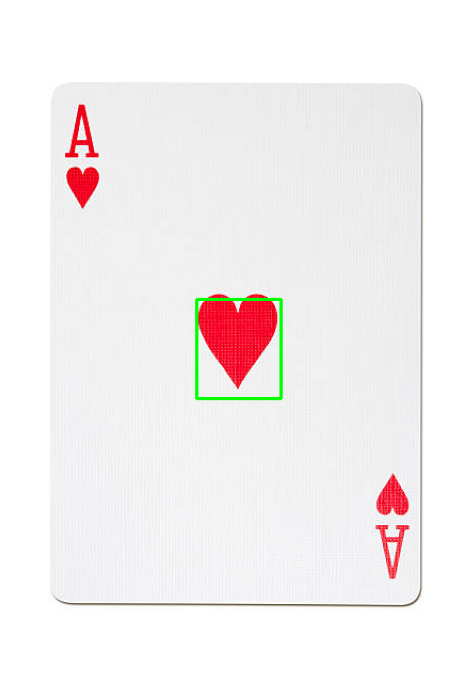

In [ ]:
# Draw final result
imageFinal = imageCard.copy()
plt.figure(figsize = (10, 6))
cv2.rectangle(
    imageFinal,
    (boxFinal[0], boxFinal[1]),
    (boxFinal[2], boxFinal[3]),
    (0, 255, 0),
    2
)
plt.imshow(imageFinal[:, :, ::-1])
plt.axis('off')
plt.show()